In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
y = snakemake_utils.get_dataset("polbook").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_results/polbook/'
! ls /data/sg/ashutiwa/final_results/airport/
DIRS = ['polbook_one/', 'polbook_two/', 'polbook_three/', 'polbook_four/', 'polbook_five/']
DATASET = 'polbook'
M = ["GCN_baseline", "GCN_r2v", "GCN_baseline_crosswalk", "GCN_r2v_crosswalk", 
     "GAT_baseline","GAT_r2v", "GAT_baseline_crosswalk", "GAT_r2v_crosswalk",
    "word2vec_baseline", "word2vec_r2v", "word2vec_baseline_crosswalk", "word2vec_r2v_crosswalk"]

TEST_ADJ_FILE='/data/sg/ashutiwa/final_results/polbook/polbook_one/polbook_test_adj.npz'
NUM_NODES=105
k=5


Using existing file polbooks.gml


airport_five  airport_one    airport_two     roc_score.pkl
airport_four  airport_three  gini_score.pkl  sp_score.pkl


# distributions of positive and negative edgeswith dot product

In [4]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [5]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [6]:
FILE_CACHE = {}
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(file)
    if file in FILE_CACHE:
        NEGATIVE_EDGE_IDX, EDGE_IDX = FILE_CACHE[file]
    else:
        NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling_sparse(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
        FILE_CACHE[file] = (NEGATIVE_EDGE_IDX, EDGE_IDX)
    print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))

    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

# word2vec baseline

In [7]:
model = "word2vec_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_word2vec_node2vec_embs.npy')
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 129


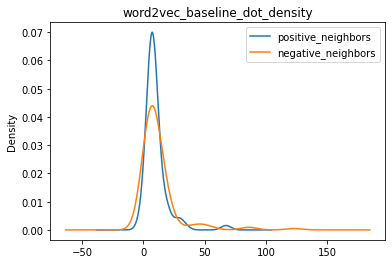

In [8]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [9]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1694.81it/s]


((525, 2), 0.04969371570987343, 0.4937804218496485, 0.3321777249767697)

# word2vec crosswalk

In [10]:
model = "word2vec_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_word2vec_node2vec_embs.npy')
A = embs[model]
A.shape


(105, 128)

selected edge_idx size: 129


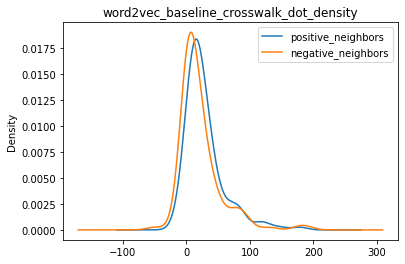

In [11]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [12]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k,batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2433.74it/s]


((525, 2), 0.06869112985358733, 0.6139054143380808, 0.38496886586941015)

# word2vec r2v

In [13]:
model = "word2vec_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET  + '_word2vec_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 129


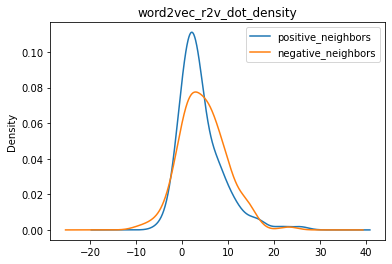

In [14]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [15]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2347.38it/s]


((525, 2), 0.05673046167729357, 0.4458265729223003, 0.36768882495255395)

# word2vec r2v crosswalk

In [16]:
model = "word2vec_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_word2vec_r2v_node2vec_embs.npy')
A = embs[model]

A.shape

(105, 128)

selected edge_idx size: 129


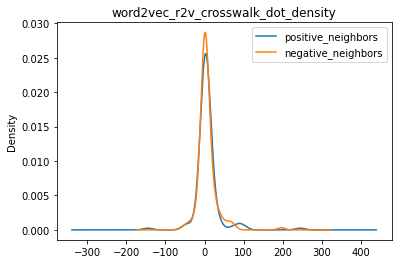

In [17]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [18]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2230.54it/s]


((525, 2), 0.046631982748847264, 0.5320593714320053, 0.3063459355748678)

# GCN ( baseline)

In [19]:
model = "GCN_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gcn_node2vec_embs.npy')
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 129


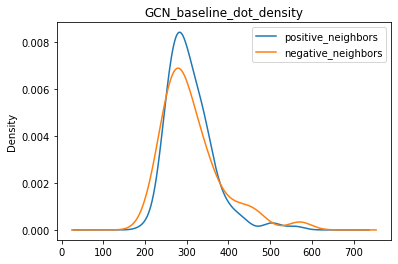

In [20]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [21]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1069.98it/s]


((525, 2), 0.06039794712344175, 0.5156541073252809, 0.3945509823770189)

# GCN ( baseline + crosswalk)

In [22]:
model = "GCN_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_node2vec_embs.npy')
A = embs[model]
A.shape


(105, 128)

selected edge_idx size: 129


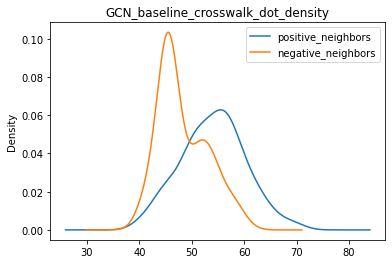

In [23]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [24]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2492.16it/s]


((525, 2), 0.059101888572023774, 0.7690643591130342, 0.3937584696614038)

# GCN ( r2v)

In [25]:
model = "GCN_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET  + '_gcn_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 129


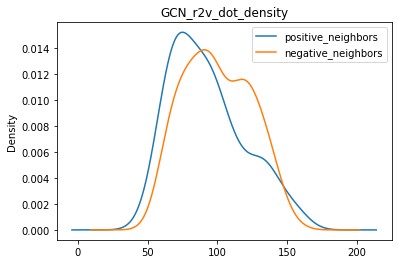

In [26]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [27]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2066.77it/s]


((525, 2), 0.0819850652049649, 0.40562466197944835, 0.46406868165043175)

# GCN ( r2v + crosswalk)

In [28]:
model = "GCN_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_r2v_node2vec_embs.npy')
A = embs[model]

A.shape

(105, 128)

selected edge_idx size: 129


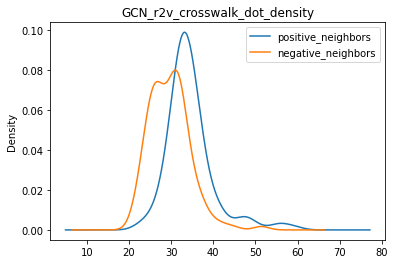

In [29]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [30]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2014.75it/s]


((525, 2), 0.060204567997706376, 0.7729102818340243, 0.39994305207694053)

# GAT ( baseline)

In [31]:
model = "GAT_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_node2vec_embs.npy')
A = embs[model]

A.shape

(105, 128)

selected edge_idx size: 129


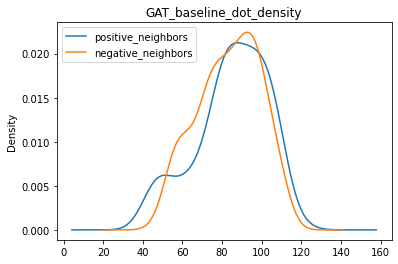

In [32]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [33]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2229.35it/s]


((525, 2), 0.07014345514084068, 0.53836908839613, 0.43022434499961415)

# GAT ( baseline + crosswalk)

In [34]:
model = "GAT_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_node2vec_embs.npy')
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 129


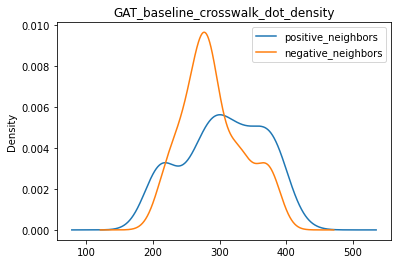

In [35]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [36]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2512.16it/s]


((525, 2), 0.051625822833505315, 0.5947959858181598, 0.3573331715360811)

# GAT ( r2v)

In [37]:
model = "GAT_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 129


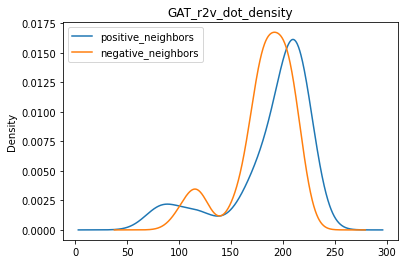

In [38]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [39]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2420.26it/s]


((525, 2), 0.0677713865782048, 0.655429361216273, 0.4095906754125773)

# GAT ( r2v + crosswalk)

In [40]:
model = "GAT_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_r2v_node2vec_embs.npy')
A = embs[model]
A.shape

(105, 128)

selected edge_idx size: 129


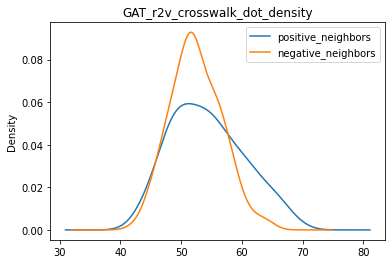

In [41]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [42]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2315.25it/s]


((525, 2), 0.06574771295823402, 0.5801934979868999, 0.4099225679759027)

# plot statistical parity scores

# gini sp scores

word2vec_baseline 0.3321777249767697
word2vec_baseline_crosswalk 0.38496886586941015
word2vec_r2v 0.36768882495255395
word2vec_r2v_crosswalk 0.3063459355748678
GCN_baseline 0.3945509823770189
GCN_baseline_crosswalk 0.3937584696614038
GCN_r2v 0.46406868165043175
GCN_r2v_crosswalk 0.39994305207694053
GAT_baseline 0.43022434499961415
GAT_baseline_crosswalk 0.3573331715360811
GAT_r2v 0.4095906754125773
GAT_r2v_crosswalk 0.4099225679759027


Text(0.5, 1.0, 'gini statistical parity scores')

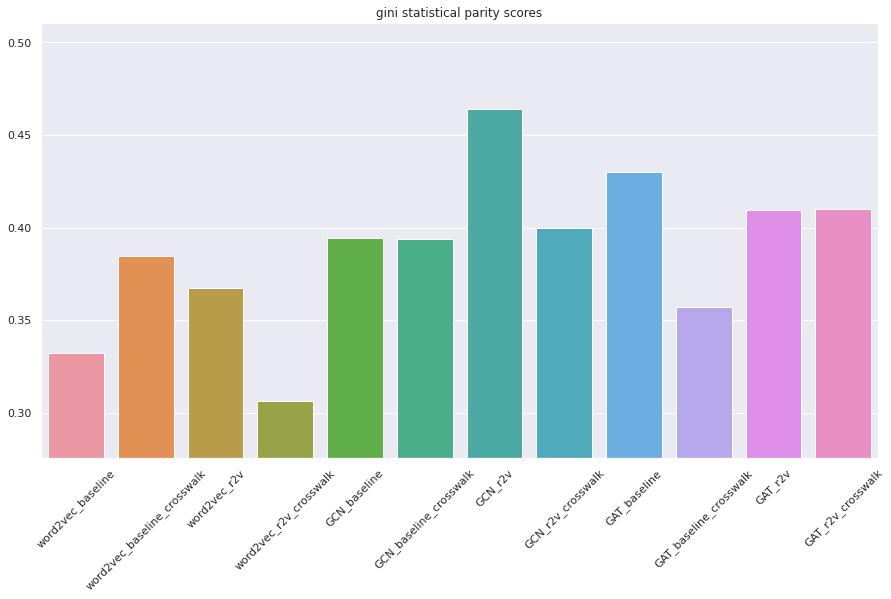

In [43]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9 , max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

word2vec_baseline 0.04969371570987343
word2vec_baseline_crosswalk 0.06869112985358733
word2vec_r2v 0.05673046167729357
word2vec_r2v_crosswalk 0.046631982748847264
GCN_baseline 0.06039794712344175
GCN_baseline_crosswalk 0.059101888572023774
GCN_r2v 0.0819850652049649
GCN_r2v_crosswalk 0.060204567997706376
GAT_baseline 0.07014345514084068
GAT_baseline_crosswalk 0.051625822833505315
GAT_r2v 0.0677713865782048
GAT_r2v_crosswalk 0.06574771295823402


Text(0.5, 1.0, 'statistical parity scores')

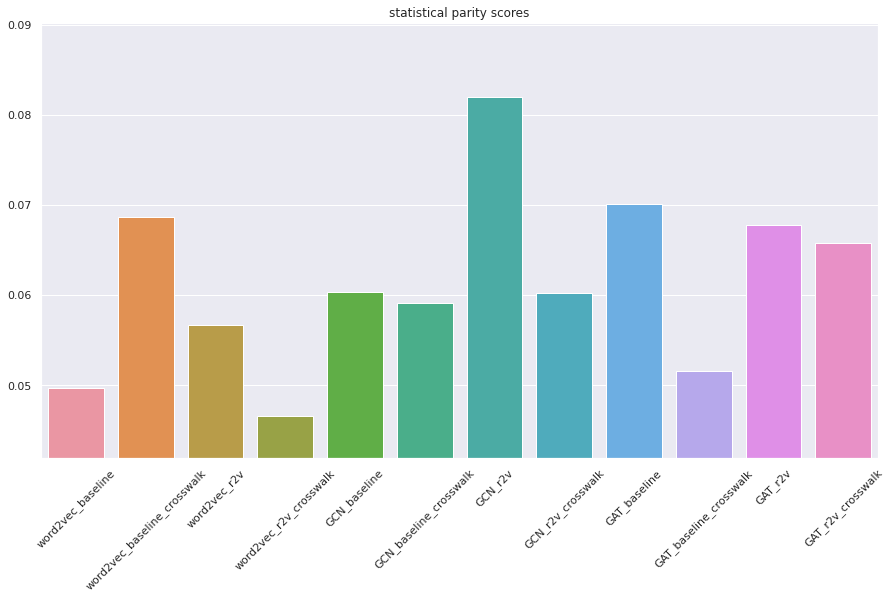

In [44]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

word2vec_baseline 0.4937804218496485
word2vec_baseline_crosswalk 0.6139054143380808
word2vec_r2v 0.4458265729223003
word2vec_r2v_crosswalk 0.5320593714320053
GCN_baseline 0.5156541073252809
GCN_baseline_crosswalk 0.7690643591130342
GCN_r2v 0.40562466197944835
GCN_r2v_crosswalk 0.7729102818340243
GAT_baseline 0.53836908839613
GAT_baseline_crosswalk 0.5947959858181598
GAT_r2v 0.655429361216273
GAT_r2v_crosswalk 0.5801934979868999


Text(0.5, 1.0, 'roc scores')

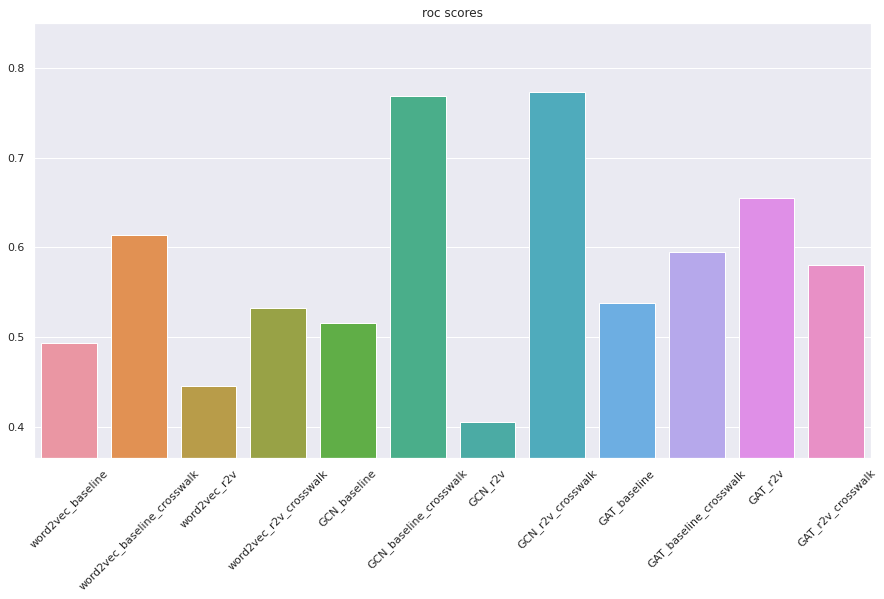

In [45]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [46]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m]
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, k, batch_size)
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2306.34it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2179.09it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2353.18it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3049.07it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1732.90it/s]


Text(0.5, 1.0, 'gini scores vs # nn')

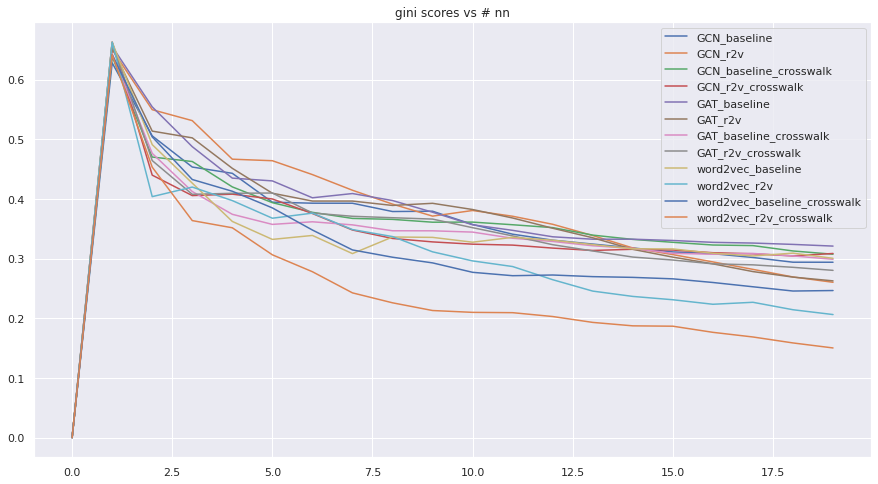

In [47]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

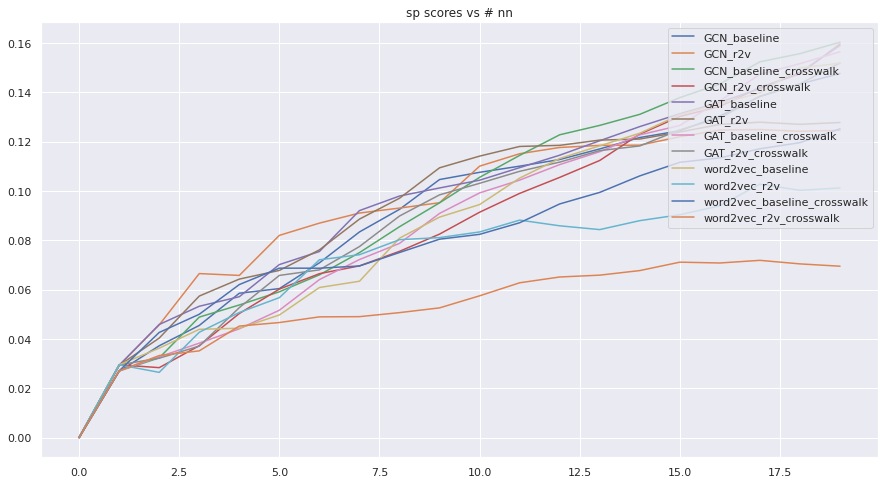

In [48]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [49]:
MODEL_NAME_2_FILE = {
    "GCN_baseline": "_gcn_node2vec_embs.npy",
    "GCN_baseline_crosswalk": "_crosswalk_gcn_node2vec_embs.npy",
    "GCN_r2v": "_gcn_r2v_node2vec_embs.npy",
    "GCN_r2v_crosswalk": '_crosswalk_gcn_r2v_node2vec_embs.npy',
    "GAT_baseline": '_gat_node2vec_embs.npy',
    "GAT_baseline_crosswalk": "_crosswalk_gat_node2vec_embs.npy",
    "GAT_r2v": "_gat_r2v_node2vec_embs.npy",
    "GAT_r2v_crosswalk": "_crosswalk_gat_r2v_node2vec_embs.npy",
    "WORD2VEC_baseline": '_word2vec_node2vec_embs.npy',
    "WORD2VEC_baseline_crosswalk": "_crosswalk_word2vec_node2vec_embs.npy",
    "WORD2VEC_r2v": "_word2vec_r2v_node2vec_embs.npy",
    "WORD2VEC_r2v_crosswalk": "_crosswalk_word2vec_r2v_node2vec_embs.npy"
}
def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        file = DATA_ROOT + d + DATASET + '_test_adj.npz'
        dot = create_dot_df(A, file)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, K, batch_size)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

selected edge_idx size: 129
selected edge_idx size: 119
selected edge_idx size: 63
selected edge_idx size: 115
selected edge_idx size: 143
selected edge_idx size: 129
selected edge_idx size: 119
selected edge_idx size: 63
selected edge_idx size: 115
selected edge_idx size: 143
selected edge_idx size: 129
selected edge_idx size: 119
selected edge_idx size: 63
selected edge_idx size: 115
selected edge_idx size: 143
selected edge_idx size: 129
selected edge_idx size: 119
selected edge_idx size: 63
selected edge_idx size: 115
selected edge_idx size: 143
selected edge_idx size: 129
selected edge_idx size: 119
selected edge_idx size: 63
selected edge_idx size: 115
selected edge_idx size: 143
selected edge_idx size: 129
selected edge_idx size: 119
selected edge_idx size: 63
selected edge_idx size: 115
selected edge_idx size: 143
selected edge_idx size: 129
selected edge_idx size: 119
selected edge_idx size: 63
selected edge_idx size: 115
selected edge_idx size: 143
selected edge_idx size: 129

Text(0.5, 1.0, 'roc scores')

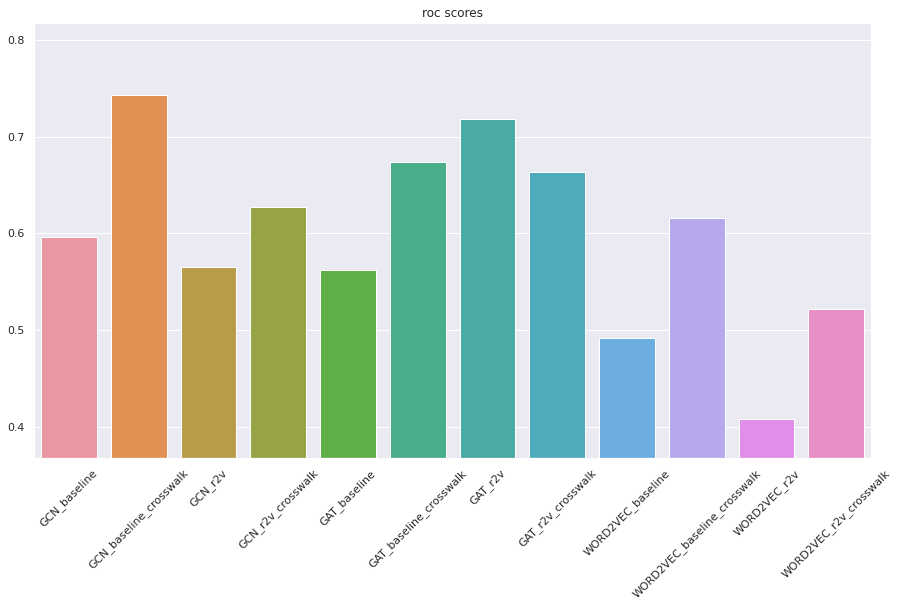

In [50]:

roc_score = {m: np.mean(roc_scores(m)) for m in MODEL_NAME_2_FILE}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2429.79it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 652.40it/s]


GCN_baseline 0.07171830882420445
GCN_baseline_crosswalk 0.05783600713202643
GCN_r2v 0.07080026781321133
GCN_r2v_crosswalk 0.05909551659521063
GAT_baseline 0.06991708816897872
GAT_baseline_crosswalk 0.05683886467033271
GAT_r2v 0.06765387618891203
GAT_r2v_crosswalk 0.058404663591445846
WORD2VEC_baseline 0.056537899867564176
WORD2VEC_baseline_crosswalk 0.05593315363955302
WORD2VEC_r2v 0.05939955884063504
WORD2VEC_r2v_crosswalk 0.044009043057249356


Text(0.5, 1.0, 'statistical parity scores')

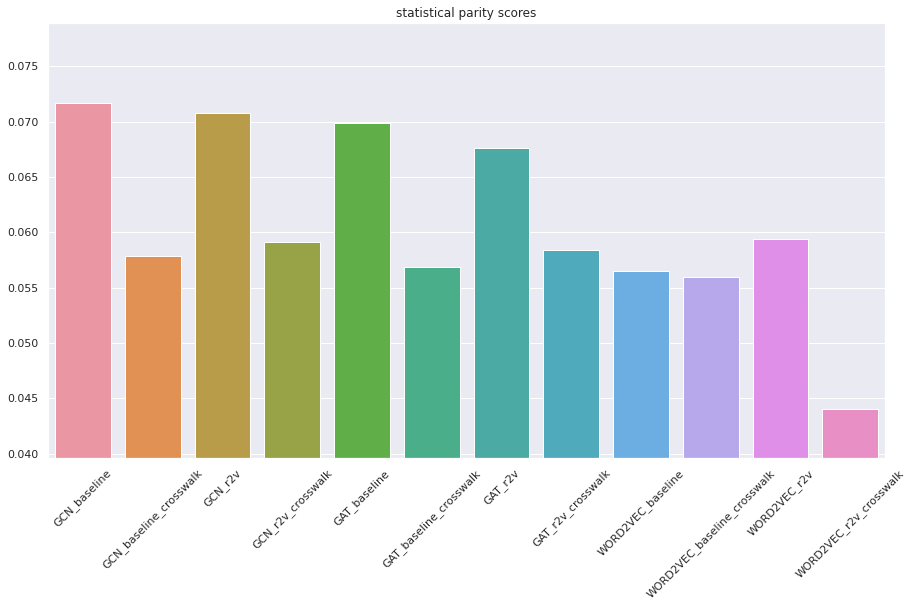

In [51]:

temp = {m: statisticalp_scores(m) for m in MODEL_NAME_2_FILE}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

GCN_baseline 0.43679532888580264
GCN_baseline_crosswalk 0.38972995079535294
GCN_r2v 0.43498353819904423
GCN_r2v_crosswalk 0.39484997481937456
GAT_baseline 0.4355363399289264
GAT_baseline_crosswalk 0.38513591779150025
GAT_r2v 0.4221197081401288
GAT_r2v_crosswalk 0.38541850521458587
WORD2VEC_baseline 0.36720131595972555
WORD2VEC_baseline_crosswalk 0.34390062570413066
WORD2VEC_r2v 0.36504165372368336
WORD2VEC_r2v_crosswalk 0.29526702253849174


Text(0.5, 1.0, 'gini statistical parity scores')

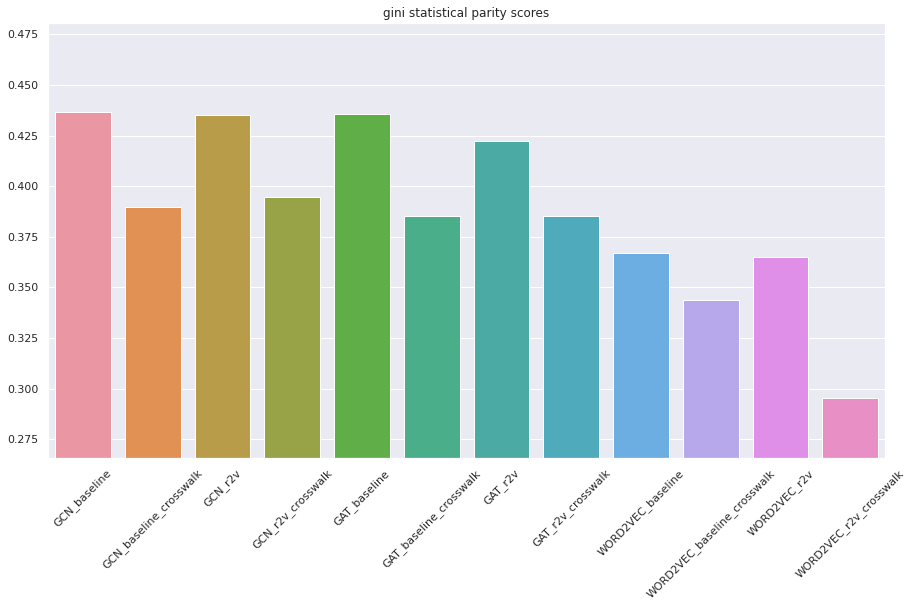

In [52]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9, max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [53]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in MODEL_NAME_2_FILE}
temp = {m: statisticalp_scores(m) for m in MODEL_NAME_2_FILE}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

selected edge_idx size: 129
selected edge_idx size: 119
selected edge_idx size: 63
selected edge_idx size: 115
selected edge_idx size: 143
selected edge_idx size: 129
selected edge_idx size: 119
selected edge_idx size: 63
selected edge_idx size: 115
selected edge_idx size: 143
selected edge_idx size: 129
selected edge_idx size: 119
selected edge_idx size: 63
selected edge_idx size: 115
selected edge_idx size: 143
selected edge_idx size: 129
selected edge_idx size: 119
selected edge_idx size: 63
selected edge_idx size: 115
selected edge_idx size: 143
selected edge_idx size: 129
selected edge_idx size: 119
selected edge_idx size: 63
selected edge_idx size: 115
selected edge_idx size: 143
selected edge_idx size: 129
selected edge_idx size: 119
selected edge_idx size: 63
selected edge_idx size: 115
selected edge_idx size: 143
selected edge_idx size: 129
selected edge_idx size: 119
selected edge_idx size: 63
selected edge_idx size: 115
selected edge_idx size: 143
selected edge_idx size: 129

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2363.25it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2199.43it/s]
